Perform Bayesian Optimization with Gaussian Process in Parallel, utilizing varous CPU'S, to speed up the search

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [2]:

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y.value_counts()/len(y)

0    0.627417
1    0.372583
Name: count, dtype: float64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [6]:
param_grid = [
    Integer(10, 120, name="n_estimators"),
    Integer(1, 5, name="max_depth"),
    Real(0.0001, 0.1, prior='log-uniform', name='learning_rate'),
    Real(0.001, 0.999, prior='log-uniform', name="min_samples_split"),
    Categorical(['log_loss', 'exponential'], name="loss"),
]


In [7]:
gbm = GradientBoostingClassifier(random_state = 42)


In [8]:
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-4,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

### Optimization with Gaussian Process

In [9]:
optimizer = Optimizer(
    dimensions = param_grid, # the hyperparameter space
    base_estimator = "GP", # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    random_state=0, 
    n_jobs=4,
)

In [10]:
# we will use 4 CPU'SystemError
#If we lop 10 times using 4 end points, we perform 40 searches in total

for i in range(10):
    x = optimizer.ask(n_points=4)
    y = Parallel(n_jobs=4)(delayed(objective)(v) for v in x)
    optimizer.tell(x, y)

In [11]:
# The evolation of the optimizer
optimizer.Xi

[[68, 4, 0.007381238832487747, 0.08704800719052391, 'exponential'],
 [118, 2, 0.00010113718979245275, 0.05725990689319986, 'log_loss'],
 [17, 3, 0.00022221129238269847, 0.17371729808265857, 'exponential'],
 [42, 4, 0.000960176974739521, 0.6793527084375192, 'exponential'],
 [38, 5, 0.053126979002083165, 0.06277193933628669, 'log_loss'],
 [28, 4, 0.005445788189169609, 0.002258808366805843, 'log_loss'],
 [56, 1, 0.0006780193306440557, 0.9274466173670369, 'exponential'],
 [42, 4, 0.08952334707464486, 0.20644568894340298, 'log_loss'],
 [68, 1, 0.0010637763908757617, 0.0037524397848558923, 'log_loss'],
 [48, 4, 0.0016815858162959685, 0.27886812907463643, 'log_loss'],
 [92, 3, 0.01633708246670054, 0.03606825343469287, 'exponential'],
 [21, 5, 0.05170535419114375, 0.020102762855887652, 'exponential'],
 [78, 4, 0.027603505264592033, 0.16124582525136621, 'exponential'],
 [108, 5, 0.06011981564956239, 0.22575450598744756, 'log_loss'],
 [120, 5, 0.0631650243892766, 0.999, 'log_loss'],
 [120, 5, 0.

In [12]:
#The accuracy 
optimizer.yi

[-0.9171413381939697,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.9296536796536796,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.929691653375864,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.9372294372294373,
 -0.9246221614642667,
 -0.9246601351864511,
 -0.9321979190400244,
 -0.9497607655502392,
 -0.9271853877117037,
 -0.9497607655502392,
 -0.9497607655502392,
 -0.9522670312143996,
 -0.9170084301663248,
 -0.9572795625427205,
 -0.9246031746031745,
 -0.9372674109516215,
 -0.9297106402369559,
 -0.9246411483253588,
 -0.9221348826611985,
 -0.9221348826611985,
 -0.9195336826915774,
 -0.949741778689147,
 -0.9447482342219184,
 -0.9170274170274171,
 -0.9472544998860788,
 -0.9447482342219184,
 -0.9447102604997341,
 -0.929691653375864,
 -0.9271284271284271,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.6256360598465861,
 -0.9572795625427205]

In [13]:
dim_names = ['n_estimators', 'max_depth', 'learning_rate', 'min_samples_split', 'loss']
tmp = pd.concat([
    pd.DataFrame(optimizer.Xi, columns=dim_names),
    pd.Series(optimizer.yi, name='accuracy')
], axis=1)

tmp.columns = dim_names + ['accuracy']
tmp.head()

,n_estimators,max_depth,learning_rate,min_samples_split,loss,accuracy
0,68,4,0.007381,0.087048,exponential,-0.917141
1,118,2,0.000101,0.057260,log_loss,-0.625636
2,17,3,0.000222,0.173717,exponential,-0.625636
3,42,4,0.000960,0.679353,exponential,-0.625636
4,38,5,0.053127,0.062772,log_loss,-0.929654


<Axes: >

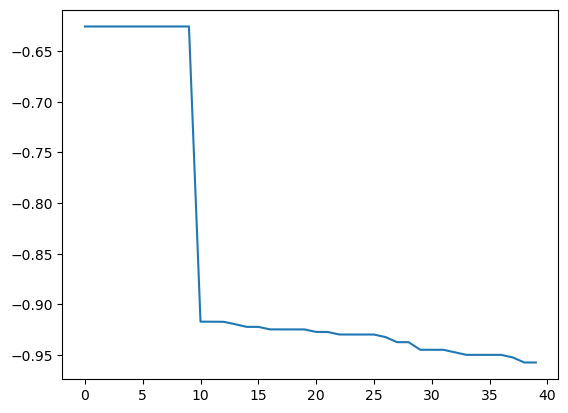

In [14]:
# Evaluate convergence of the search
tmp['accuracy'].sort_values(ascending=False).reset_index(drop = True).plot()